# Writing Neural Networks

Writing neural networks using tensorflow's low level api is an essential skill for implementing most research papers.  The ability to translate from mathematical equations into code, is incredibly powerful.  Not only because you can take the work of others to a functional place, but because you can come up with your own ideas, mathematically, prove some properties and then do an implementation.  The process of reading and understanding techniques through mathematics and then implementing them in code is the most productive way to make progress in your development as a scientist and researcher.  It's also very useful for being an effective engineer.  Through mathematics we can quickly understand and verify that some property ought to hold.  Once you understand the definitions and consequences of an idea in mathematics, verification of it's validity often takes a day or so, much faster than the verification of scientific quantities, because mathematics works in the world of absolute truth.  This means there aren't really grey areas, so you can make definitive statements.  While in general, science does not follow this binary notion of absolutes, hence the extensive use of statistics, scientific tools are primarily written in the language of mathematics.  A given idea or theory (of the real world) may seem enticing, but without scientific evidence to back it up, the theory means little. 

That said, once a theory can be validated through statistical analysis, it can be folded into a theoretical analysis.  It is from time to time even possible to draw conclusions beyond the phenomenon of inquiry which guides future discovery.  This has been seen several times from the world of mathematical physics.  One striking example of this is the discovery of blackholes which were theorized a century before they were physically discovered.

Note: If you don't know how to write tensorflow code, please see [this](https://github.com/EricSchles/datascience_book/blob/master/python_programming/tensorflow_basics/Tensorflow%20Basics.ipynb) notebook.  

## The Neural Network framework

If you aren't already familar with neural networks, I suggest reading [this chapter](https://github.com/EricSchles/datascience_book/blob/master/5/An%20Introduction%20to%20Neural%20Networks%20-%2007.ipynb) first.  

In general, neural nets are essentially a collection of linear regression models tied together through a meta optimization algorithm called backpropagation.  The linear regression models are sometimes tied together with an 'activation' function, which is just a secondary transform applied after the linear regression optimization takes place.  We've already seen that we can use stochastic gradient descent to optimize a linear regression model [here](https://github.com/EricSchles/datascience_book/blob/master/2/An%20Introduction%20to%20Regression%20-%2003.ipynb) and that there is a linear algebra equivalent [here](https://github.com/EricSchles/datascience_book/blob/master/5/An%20Introduction%20to%20Neural%20Networks%20-%2007.ipynb).  Neural networks essentially tie these two ideas together and do _both_ optimization strategies.  The linear algebra optimization strategy happens locally with the so called 'forward pass' and then the gradient is used explicitly to update the weights on the 'backward pass'.  But keep in mind there are two optimizations working together in tandem.  

So really a neural network is just an ensemble of sort of linear models or models with easy derivates and each 'layer' of the network is just a given model, optimizing a bit of the ensemble in an explicit way.  The power of neural networks come from their flexability.  Unlike random forests or gradient boosted trees which either optimize in parallel or in sequence, neural networks can do both.  Some of the layers can optimize for certain inputs and others can optimize for others.  Or we can feed copies of the same data to a very wide neural network, which essentially acts like a random forest.  We'll see a number of architectures and ideas in this chapter for how to write down different neural network architectures, EVEN if they aren't necessarily useful, it's still good practice to see how to work with these different tools.

## A first primitive example

Our first example is going to be a purely linear model that simply does essentially linear regression.

In [44]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

class LinearRegression:
    def __init__(self, shape, learning_rate=0.5):
        array = np.random.normal(0, 1, size=shape)
        array = tf.cast(array, tf.float32)
        self.weights = tf.Variable(array)
        self.bias = tf.Variable(1.0)
        self.learning_rate = learning_rate
        
    def predict(self, x):
        return tf.tensordot(x, self.weights, axes=1) + self.bias
    
    def loss(self, y_pred, y_true):
        return tf.reduce_mean(
           tf.square(y_pred - y_true)
        )
    
    def update_weights(self, X_train, y_true):
        with tf.GradientTape() as tape:
            y_pred = self.predict(X_train)
            loss = self.loss(y_pred, y_true)
        gradients = tape.gradient(
            loss, [self.weights, self.bias]
        )
        self.weights.assign_sub(gradients[0] * self.learning_rate)
        self.bias.assign_sub(gradients[1] * self.learning_rate)

X, y = make_regression()
X_train, X_test, y_train, y_test = train_test_split(X, y)
epochs = 10
lin_reg = LinearRegression(X_train.shape[1])
X_train = tf.cast(
    tf.constant(X_train), 
    tf.float32
)
X_test = tf.cast(
    tf.constant(X_test),
    tf.float32
)
y_train = tf.cast(
    tf.constant(y_train),
    tf.float32
)
y_test = tf.cast(
    tf.constant(y_test),
    tf.float32
)
for i in range(epochs):
    lin_reg.update_weights(X_train, y_train)
    
y_pred = lin_reg.predict(X_test)
loss = lin_reg.loss(y_pred, y_test)
print("MSE:", loss)

MSE: tf.Tensor(27385605000000.0, shape=(), dtype=float32)


There are a couple of things to note here which are mandatory in order for tensorflow to train a mode successfully:

1. You must cast everything to the same type - as an exercise try copy/pasting the above code into a new cell and remove all the type casting (the code with tf.cast).  It fails because all the X, y data is treated as doubles, not floats.

2. You must call predict and your loss function inside of the gradient tape context but must apply your gradient updates outside the gradient tape context.  This choice has always felt somewhat arbitrary to me.  However, because of how distributed training works and the fact that only some variables are *trainable* while others are frozen, we need some way to manage state.  It's an annoying trade off, but it needed to be made somewhere.  Fortunately, the code is not particularly ugly, just very pedantic

3. In general tensors products are not commutative, so the order of your parameters in your tensor product matter.  This can be seen in the predict function defined above.  If we tried changing around the order then our code would not work.

4. Notice the use of tf.Variable for our weights and bias term.  If we made those tf.constant instead, then our gradient tape wouldn't let us update our variables.

These basic concerns may seem like an impedement, but this code is far cleaner and scalable than the vanilla numpy implementation found [here in the section: A Naive Implementation of a Neural Network](https://github.com/EricSchles/datascience_book/blob/master/5/An%20Introduction%20to%20Neural%20Networks%20-%2007.ipynb).  Also, we don't need to worry about figuring out the derivative for each of our activation functions.  While some people love calculus (like myself, yes even in higher dimensions), many programmers don't.  Which is why automatic differentiation implemented in packages like tensorflow has openned up a world of mathematics to programmers.  

Now that we've seen how the tensorflow framework can be used to train a neural network, let's do a multilayer preceptron.  This will be our first multilayer neural network or ensemble of layers.  We'll look at a deep neural network first, deep because it trains the layers in sequence.  And then we'll look at a wide neural network, because it will train the layers in parallel.

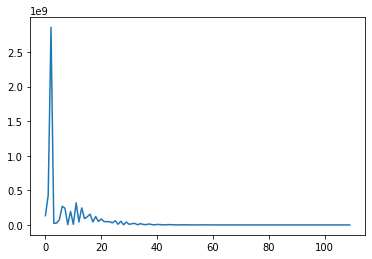

In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class Dense(tf.Module):
    def __init__(self, output_size, name=None, final=False):
        super().__init__(name=name)
        if final:
            weights = np.random.normal(0, 1, size=output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        else:
            weights = np.random.normal(0, 1, size=output_size * output_size)
            weights = weights.reshape(output_size, output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        self.bias = tf.Variable(1.0)
        
    def __call__(self, x):
        return tf.tensordot(x, self.weights, axes=1) + self.bias

        
class NeuralNet(tf.Module):
    def __init__(self, X_in, X_out, optimizer):
        super(NeuralNet, self).__init__()
        self.layer_one = Dense(X_out)
        self.layer_two = Dense(X_out)
        self.layer_three = Dense(X_out, final=True)
        self.optimizer = optimizer
        
    def _collect_trainable_variables(self):
        return [
            self.layer_one.weights,
            self.layer_one.bias,
            self.layer_two.weights,
            self.layer_two.bias,
            self.layer_three.weights,
            self.layer_three.bias
        ]
    
    def __call__(self, x):
        return self.predict(x)
    
    def predict(self, x):
        res = self.layer_one(x)
        res = self.layer_two(res)
        return self.layer_three(res)

    def loss(self, y_pred, y_true):
        return tf.reduce_mean(
           tf.square(y_pred - y_true)
        )
    
    def step(self, x, y):
        x = tf.cast(x, tf.float32)
        y = tf.cast(y, tf.float32)
        with tf.GradientTape() as tape:
            pred = self.predict(x)
            loss = self.loss(pred, y)
        trainable_variables = self._collect_trainable_variables()
        gradients = tape.gradient(loss, trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

if __name__ == '__main__':
    X, y = make_regression(n_samples=1000, n_features=100)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    X_train = tf.cast(
        tf.constant(X_train), 
        tf.float32
    )
    X_test = tf.cast(
        tf.constant(X_test),
        tf.float32
    )
    y_train = tf.cast(
        tf.constant(y_train),
        tf.float32
    )
    y_test = tf.cast(
        tf.constant(y_test),
        tf.float32
    )

    learning_rate = 0.9
    optimizer = tf.optimizers.Adam(learning_rate)
    nn = NeuralNet(1000, X_train.shape[1], optimizer)
    num_steps = 110
    losses = []
    for step in range(num_steps):
        nn.step(X_train, y_train)
        pred = nn(X_test)
        loss = nn.loss(pred, y_test)
        losses.append(loss)
    plt.plot(losses)

Some things to note here that may not be obvious:

1. We need to pass the collection of trainable variables to our gradient, otherwise they won't update explicitly.  We did do this in the first example, but this is more formalized now.  Notice, tensorflow expects the weights in order AND the ordering is expected to be weights then bias for each layer.

2. We must past the output of the previous layer into the next layer as input

3. Now we make use of the adam optimizer to update our weights through gradient update

4. We generalize our sub-models into a layer object called Dense, which does linear regression layer by layer.  

5. We only want one output vector, our predictions for the final layer, so we need to pass an optional parameter called final to our Dense object, which acts like linear regression.  All the layers before output a square weight matrix.  

Note: In this way we can see that neural networks actually do a series of optimization steps in sequence, where each additional layer after the first essentially starts with an optimized version of the previous layer (through the matrix multiplication) and then the optimization procedure itself more or less gets updated on the backward pass.  So we can think of a neural network as optimizing an optimization through backpropagation.

Now let's see a wide neural network:

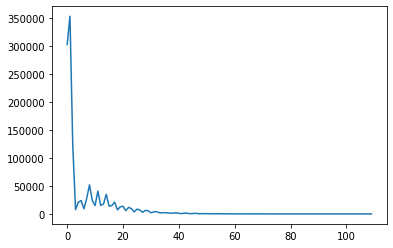

In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class Dense(tf.Module):
    def __init__(self, output_size, name=None, final=False):
        super().__init__(name=name)
        if final:
            weights = np.random.normal(0, 1, size=output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        else:
            weights = np.random.normal(0, 1, size=output_size * output_size)
            weights = weights.reshape(output_size, output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        self.bias = tf.Variable(1.0)
        
    def __call__(self, x):
        return tf.tensordot(x, self.weights, axes=1) + self.bias

        
class NeuralNet(tf.Module):
    def __init__(self, X_in, X_out, optimizer):
        super(NeuralNet, self).__init__()
        self.layer_one = Dense(X_out)
        self.layer_two = Dense(X_out)
        self.layer_three = Dense(X_out, final=True)
        self.optimizer = optimizer
        
    def _collect_trainable_variables(self):
        return [
            self.layer_one.weights,
            self.layer_one.bias,
            self.layer_two.weights,
            self.layer_two.bias,
            self.layer_three.weights,
            self.layer_three.bias
        ]
    
    def __call__(self, x):
        return self.predict(x)
    
    def predict(self, x):
        res_one = self.layer_one(x)
        res_two = self.layer_two(x)
        average_weights = tf.reduce_mean(
            [res_one, res_two], axis=0
        )
        return self.layer_three(average_weights)

    def loss(self, y_pred, y_true):
        return tf.reduce_mean(
           tf.square(y_pred - y_true)
        )
    
    def step(self, x, y):
        x = tf.cast(x, tf.float32)
        y = tf.cast(y, tf.float32)
        with tf.GradientTape() as tape:
            pred = self.predict(x)
            loss = self.loss(pred, y)
        trainable_variables = self._collect_trainable_variables()
        gradients = tape.gradient(loss, trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

if __name__ == '__main__':
    X, y = make_regression(n_samples=1000, n_features=100)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    X_train = tf.cast(
        tf.constant(X_train), 
        tf.float32
    )
    X_test = tf.cast(
        tf.constant(X_test),
        tf.float32
    )
    y_train = tf.cast(
        tf.constant(y_train),
        tf.float32
    )
    y_test = tf.cast(
        tf.constant(y_test),
        tf.float32
    )
    
    learning_rate = 0.9
    optimizer = tf.optimizers.Adam(learning_rate)
    
    nn = NeuralNet(1000, X_train.shape[1], optimizer)
    num_steps = 110
    losses = []
    for step in range(num_steps):
        nn.step(X_train, y_train)
        pred = nn(X_test)
        loss = nn.loss(pred, y_test)
        losses.append(loss)
    plt.plot(losses)

This is the first strategy we see for optimizing a wide network - take the average of the weights at each update step.  We could also sum the weights:

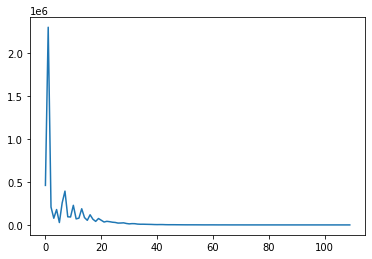

In [10]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class Dense(tf.Module):
    def __init__(self, output_size, name=None, final=False):
        super().__init__(name=name)
        if final:
            weights = np.random.normal(0, 1, size=output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        else:
            weights = np.random.normal(0, 1, size=output_size * output_size)
            weights = weights.reshape(output_size, output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        self.bias = tf.Variable(1.0)
        
    def __call__(self, x):
        return tf.tensordot(x, self.weights, axes=1) + self.bias

        
class NeuralNet(tf.Module):
    def __init__(self, X_in, X_out, optimizer):
        super(NeuralNet, self).__init__()
        self.layer_one = Dense(X_out)
        self.layer_two = Dense(X_out)
        self.layer_three = Dense(X_out, final=True)
        self.optimizer = optimizer
        
    def _collect_trainable_variables(self):
        return [
            self.layer_one.weights,
            self.layer_one.bias,
            self.layer_two.weights,
            self.layer_two.bias,
            self.layer_three.weights,
            self.layer_three.bias
        ]
    
    def __call__(self, x):
        return self.predict(x)
    
    def predict(self, x):
        res_one = self.layer_one(x)
        res_two = self.layer_two(x)
        average_weights = tf.reduce_sum(
            [res_one, res_two], axis=0
        )
        return self.layer_three(average_weights)

    def loss(self, y_pred, y_true):
        return tf.reduce_mean(
           tf.square(y_pred - y_true)
        )
    
    def step(self, x, y):
        x = tf.cast(x, tf.float32)
        y = tf.cast(y, tf.float32)
        with tf.GradientTape() as tape:
            pred = self.predict(x)
            loss = self.loss(pred, y)
        trainable_variables = self._collect_trainable_variables()
        gradients = tape.gradient(loss, trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

if __name__ == '__main__':
    X, y = make_regression(n_samples=1000, n_features=100)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    X_train = tf.cast(
        tf.constant(X_train), 
        tf.float32
    )
    X_test = tf.cast(
        tf.constant(X_test),
        tf.float32
    )
    y_train = tf.cast(
        tf.constant(y_train),
        tf.float32
    )
    y_test = tf.cast(
        tf.constant(y_test),
        tf.float32
    )
    
    learning_rate = 0.9
    optimizer = tf.optimizers.Adam(learning_rate)
    
    nn = NeuralNet(1000, X_train.shape[1], optimizer)
    num_steps = 110
    losses = []
    for step in range(num_steps):
        nn.step(X_train, y_train)
        pred = nn(X_test)
        loss = nn.loss(pred, y_test)
        losses.append(loss)
    plt.plot(losses)

And finally we can do a reduce multiply:

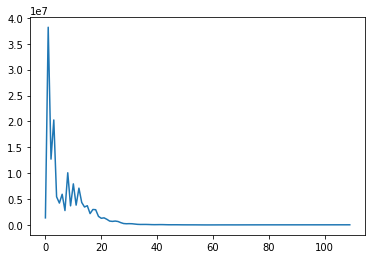

In [12]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class Dense(tf.Module):
    def __init__(self, output_size, name=None, final=False):
        super().__init__(name=name)
        if final:
            weights = np.random.normal(0, 1, size=output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        else:
            weights = np.random.normal(0, 1, size=output_size * output_size)
            weights = weights.reshape(output_size, output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        self.bias = tf.Variable(1.0)
        
    def __call__(self, x):
        return tf.tensordot(x, self.weights, axes=1) + self.bias

        
class NeuralNet(tf.Module):
    def __init__(self, X_in, X_out, optimizer):
        super(NeuralNet, self).__init__()
        self.layer_one = Dense(X_out)
        self.layer_two = Dense(X_out)
        self.layer_three = Dense(X_out, final=True)
        self.optimizer = optimizer
        
    def _collect_trainable_variables(self):
        return [
            self.layer_one.weights,
            self.layer_one.bias,
            self.layer_two.weights,
            self.layer_two.bias,
            self.layer_three.weights,
            self.layer_three.bias
        ]
    
    def __call__(self, x):
        return self.predict(x)
    
    def predict(self, x):
        res_one = self.layer_one(x)
        res_two = self.layer_two(x)
        average_weights = tf.reduce_prod(
            [res_one, res_two], axis=0
        )
        return self.layer_three(average_weights)

    def loss(self, y_pred, y_true):
        return tf.reduce_mean(
           tf.square(y_pred - y_true)
        )
    
    def step(self, x, y):
        x = tf.cast(x, tf.float32)
        y = tf.cast(y, tf.float32)
        with tf.GradientTape() as tape:
            pred = self.predict(x)
            loss = self.loss(pred, y)
        trainable_variables = self._collect_trainable_variables()
        gradients = tape.gradient(loss, trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

if __name__ == '__main__':
    X, y = make_regression(n_samples=1000, n_features=100)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    X_train = tf.cast(
        tf.constant(X_train), 
        tf.float32
    )
    X_test = tf.cast(
        tf.constant(X_test),
        tf.float32
    )
    y_train = tf.cast(
        tf.constant(y_train),
        tf.float32
    )
    y_test = tf.cast(
        tf.constant(y_test),
        tf.float32
    )
    
    learning_rate = 0.9
    optimizer = tf.optimizers.Adam(learning_rate)
    
    nn = NeuralNet(1000, X_train.shape[1], optimizer)
    num_steps = 110
    losses = []
    for step in range(num_steps):
        nn.step(X_train, y_train)
        pred = nn(X_test)
        loss = nn.loss(pred, y_test)
        losses.append(loss)
    plt.plot(losses)

As you can see, all three methods produce more or less the same result.  Averaging seems to be the most obvious way to build wide networks, although summing is probably the fastest training time is a concern.  

Now that we've seen a number of variations of general network patterns, let's begin to add non-linearities, we'll only do this for deep neural networks because the ideas are obvious and translate directly to wide networks:

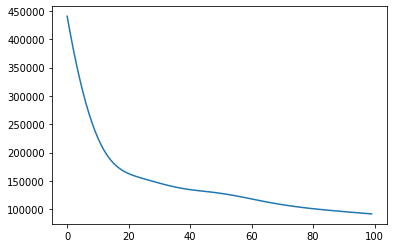

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from tensorflow.nn import (
    tanh,
    leaky_relu,
    silu,
    relu,
    selu
)
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class Dense(tf.Module):
    def __init__(self, output_size, activation='linear', name=None, final=False):
        super().__init__(name=name)
        if final:
            weights = np.random.normal(0, 1, size=output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        else:
            weights = np.random.normal(0, 1, size=output_size * output_size)
            weights = weights.reshape(output_size, output_size)
            weights = tf.cast(weights, tf.float32)
            self.weights = tf.Variable(weights)
        self.bias = tf.Variable(1.0)
        self.activation_name = activation
        
    def get_activation(self):
        activation_map = {
            'linear': None,
            'tanh': tanh,
            'leaky_relu': leaky_relu,
            'silu': silu,
            'relu': relu,
            'selu': selu
        }
        return activation_map[self.activation_name]
        
    def __call__(self, x):
        activation = self.get_activation()
        if activation:
            return activation(tf.tensordot(x, self.weights, axes=1)) + self.bias
        else:
            return tf.tensordot(x, self.weights, axes=1) + self.bias

        
class NeuralNet(tf.Module):
    def __init__(self, X_in, X_out, optimizer):
        super(NeuralNet, self).__init__()
        self.layer_one = Dense(X_out, activation='relu')
        self.layer_two = Dense(X_out, activation='selu')
        self.layer_three = Dense(X_out, activation='linear', final=True)
        self.optimizer = optimizer
        
    def _collect_trainable_variables(self):
        return [
            self.layer_one.weights,
            self.layer_one.bias,
            self.layer_two.weights,
            self.layer_two.bias,
            self.layer_three.weights,
            self.layer_three.bias
        ]
    
    def __call__(self, x):
        return self.predict(x)
    
    def predict(self, x):
        res = self.layer_one(x)
        res = self.layer_two(res)
        return self.layer_three(res)

    def loss(self, y_pred, y_true):
        return tf.reduce_mean(
           tf.square(y_pred - y_true)
        )
    
    def step(self, x, y):
        x = tf.cast(x, tf.float32)
        y = tf.cast(y, tf.float32)
        with tf.GradientTape() as tape:
            pred = self.predict(x)
            loss = self.loss(pred, y)
        trainable_variables = self._collect_trainable_variables()
        gradients = tape.gradient(loss, trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

if __name__ == '__main__':
    X, y = make_regression(n_samples=1000, n_features=100)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    X_train = tf.cast(
        tf.constant(X_train), 
        tf.float32
    )
    X_test = tf.cast(
        tf.constant(X_test),
        tf.float32
    )
    y_train = tf.cast(
        tf.constant(y_train),
        tf.float32
    )
    y_test = tf.cast(
        tf.constant(y_test),
        tf.float32
    )

    learning_rate = 1e-3
    optimizer = tf.optimizers.Adam(learning_rate)
    nn = NeuralNet(1000, X_train.shape[1], optimizer)
    num_steps = 100
    losses = []
    for step in range(num_steps):
        nn.step(X_train, y_train)
        pred = nn(X_test)
        loss = nn.loss(pred, y_test)
        losses.append(loss)
    plt.plot(losses)

As you can see, adding non-linearities to our network is very easy!  We simply add it after we do our linear optimization through our dot product and we are essentially done!

Let's do a quick review of the shapes of our non-linearities:

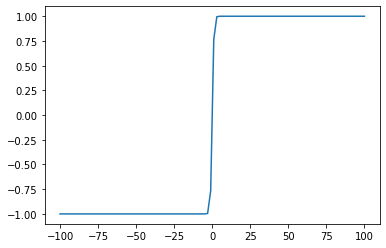

In [10]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-100, 100, num=100)
y = tanh(x)
plt.plot(x, y)

As you can see, the tanh function basically collapses our outputspace between -1 and 1 despite how big our predictions get.  This is great for dealing with exploding gradients.

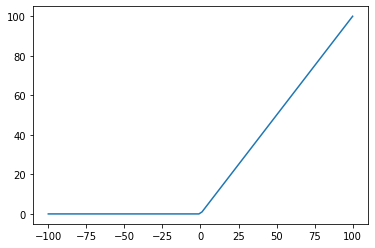

In [11]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-100, 100, num=100)
y = relu(x)
plt.plot(x, y)

The ReLU function is piece-wise linear with a discontinuity at zero.  This allows us to linear sort of a 'tree' like structure for our data with the discontinuity acting like a break so we can fit a series of smaller linear sections with our models.  This turns out to be very flexible.

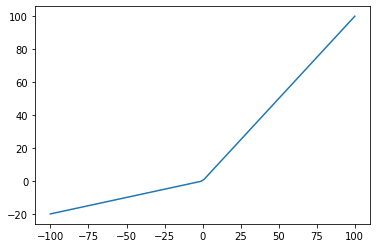

In [12]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-100, 100, num=100)
y = leaky_relu(x)
plt.plot(x, y)

Leaky ReLU retains the discontinuity so that we can have a 'smooth' piecewise linear model.  But the tail of the function is more flexible allowing us to fit more curvy functions.  This added flexibility can be both a benefit or negative.  It's best to use Leaky ReLUs on data with lots of breaks and changes in the second derivative.

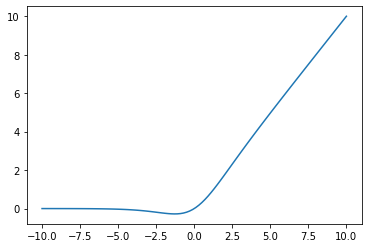

In [14]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, num=100)
y = silu(x)
plt.plot(x, y)

The SiLU activation function is slightly curvier than ReLU but basically has the same idea.  This function makes use of a sigmoid.

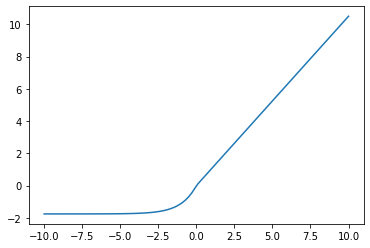

In [15]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, num=100)
y = selu(x)
plt.plot(x, y)

The SeLU is pretty similar to the SiLU activation function and accomplishs more or less the same thing except it uses a scaling factor and simple exponential instead of a sigmoid.  Notice also the SeLU drops down to -2 to instead of 0, so it's a little more flexible and a little faster.